In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read();return HTML(styles)
css_styling()


<figure>
<IMG SRC="images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 9: Two-dimensional gridding

<figure>
    <IMG SRC="./images/1962map.jpg" WIDTH=420 ALIGN="right" STYLE="padding-left:20px" ALT="http://www.wunderground.com/blog/weatherhistorian/world-and-us-anticyclonic-high-barometric-pressure-records">
</figure>

Just like for linear interpolation, it can often happen that we have data points irregularly sampled in two dimensions that we would like to put onto a regular grid in two dimensions.  i.e. imagine we have a network of weather stations that are irregularly placed geographically, and we want to put their pressure values on a regular grid in space to make a contour plot from (like the example to the right).

There are a three general approaches to this problem.  The first is global, in that you weight all the datapoints by their distance from the point you want to interpolate to.  The second is local, and you need to find the "nearest neighbours" to your interpolation point.  The third is good if you have a lot of data: you can simply bin and average the data into spatial bins to get a gridded data set.

## Setting up the Problem

Suppose we have a list of data that has an $x_n$ and $y_n$ co-ordinate, and a data value at each data point,  $z_n$.  Then the goal is to estimate  the value of $z_i$ at some point ($x_i,y_i$). Indeed, usually we want a whole grid of such points, but to do that we just iterate over the grid points.  

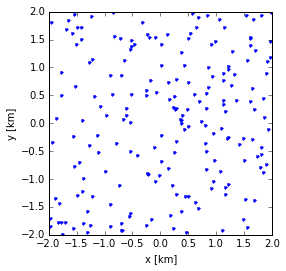

In [2]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from scipy import interpolate
from scipy import ndimage
import scipy.signal as signal
%matplotlib inline

# make up some randomly distributed data
seed(1234)
npts = 200
# the randomly distributed data points $x_n,y_n$:
x=uniform(-2,2,npts)
y=uniform(-2,2,npts)
fig,ax=plt.subplots(1,1)
ax.plot(x,y,'.',markersize=6)
ax.set_aspect(1);ax.set_xlabel('x [km]');ax.set_ylabel('y [km]')

Now we want to define the data at each of these grid points $z_n$.  It is nice to use something that is analytic so we say that 

$$z=\cos(x)chirp(y)$$ 

where $chirp$ sweeps a freqeuncy range.  

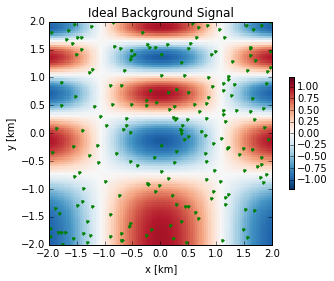

In [7]:
z = np.cos(x*2*np.pi/4.3)*signal.chirp(y+2.,f0=.05,t1=4.,f1=1.)
# lets also get it on the grid.
xi = np.linspace(-2.,2.,100)
yi = np.linspace(-2.,2.,100)
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
X,Y=np.meshgrid(xi,yi)
zideal = np.cos(X*2*np.pi/4.3)*signal.chirp(Y+2,f0=.05,t1=4.,f1=1)
fig,ax=plt.subplots(1,1)
pcm=ax.pcolormesh(X,Y,zideal,cmap='RdBu_r')
pcm.set_clim([-1.2,1.2])
plt.colorbar(pcm,ax=ax,shrink=0.5)
ax.plot(x,y,'.g',markersize=6)
ax.set_aspect(1);ax.set_xlabel('x [km]');ax.set_ylabel('y [km]');ax.set_title('Ideal Background Signal')

The goal of the interpolation is to be able to reproduce the image in the pcolor plot, using only the data at the green dots.

## Binning method

A very simple method is to bin the data, and if you have enough data that can work quite well.  From the above we will see that we can easily enough bin the low-frequency data, but the fidelity of the high-frequency data (near the top of the image) will degrade.

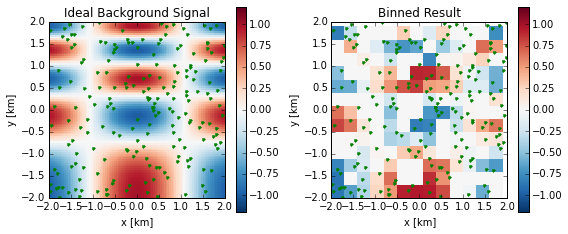

In [11]:
xbin = np.arange(-2.,2.,0.3)
ybin = np.arange(-2.,2.,0.3)
Z = np.zeros((len(xbin),len(ybin)))
n = 0.*Z
for i in range(len(x)):
    if (x[i]>xbin[0]) & (y[i]>ybin[0]):
        xind = np.where(x[i]>xbin)[0][-1]
        yind = np.where(y[i]>ybin)[0][-1]
        Z[yind,xind]+=z[i]
        n[yind,xind]+=1
Z[n>0]=Z[n>0]/n[n>0]

def plotCompareInterp(xb,yb,Zb,titl='Binned Result'):
    fig,ax=plt.subplots(1,2,figsize=(8,6))
    pcm=ax[0].pcolormesh(X,Y,zideal,cmap='RdBu_r')
    pcm.set_clim([-1.2,1.2])
    plt.colorbar(pcm,ax=ax[0],shrink=0.5)
    ax[0].plot(x,y,'.g',markersize=6)
    ax[0].set_aspect(1);ax[0].set_xlabel('x [km]');ax[0].set_ylabel('y [km]');ax[0].set_title('Ideal Background Signal')

    pcm=ax[1].pcolormesh(xb,yb,ma.masked_invalid(Zb),cmap='RdBu_r')
    pcm.set_clim([-1.2,1.2])
    plt.colorbar(pcm,ax=ax[1],shrink=0.5)
    ax[1].plot(x,y,'.g',markersize=6)
    ax[1].set_aspect(1);ax[1].set_xlabel('x [km]');ax[1].set_ylabel('y [km]');ax[1].set_title(titl)
    plt.tight_layout()
plotCompareInterp(xbin,ybin,Z)

So, this is not too successful, because there are not enough data points to resolve the features.  That doesn't mean its a bad method (I use this a lot in real life).  Its the same problem as the sampling theorem - your data needs to be more fequent than the signal you are trying to resolve.  

## Global interpolation

Here we say that our interpolated value is a weighted sum of all the raw data points: 

$$z_i = \sum_{n=0}^{N-1} w_{ni}(x_n,y_n)\  z_n$$ 

where the weight $w_{ni}(x_n,y_n)$ depends on the distance between the data point $x_n,y_n$ and the interpolated point $x_i,y_i$.  A simple model is to assume it is inversely proportional to the distance squared:

$$ w_{ni}= \frac{A}{\left(x_n-x_i \right)^2+\left(y_n-y_i \right)^2}$$ 

where $A$ is chosen so $\sum_{n=0}^{N-1}w_{ni}=1$

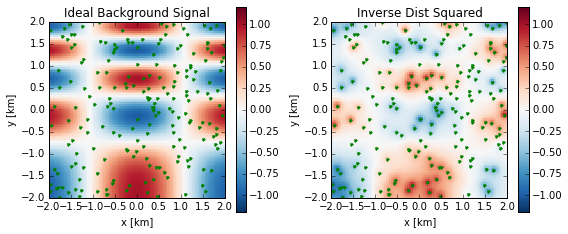

In [12]:
nx = len(xi)
ny = len(yi)
Zi = np.zeros((ny,nx))
for i in range(nx):
    for j in range(ny):
        w = 1./((xi[i]-x)**2+(yi[j]-y)**2)
        w=w/np.sum(w)
        Zi[j,i]=np.sum(w*z)    
plotCompareInterp(xi,yi,Zi,titl='Inverse Dist Squared')

This simple algorithm is not too bad; the overall structure is clear, and the value at the data points is correct (as it has to be), but the results are very diffuse  because the roll-off of $1/r^2$ is not very strong.  We could have chosen higher orders of $1/r$, but that is a little bit imprecise.  A complimentary approach is to make the weight fall off exponentially with a fixed width to the exponential:

$$ w = \mathrm{e}^{-r^2/(2\sigma^2)}$$

where $\sigma$ is a "radius".  The smaller $\sigma$, the less smoothing and the more "jagged" the interpolation.  The larger $\sigma$, the more smoothed out the interpolation:

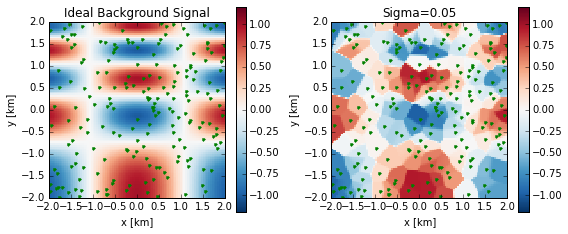

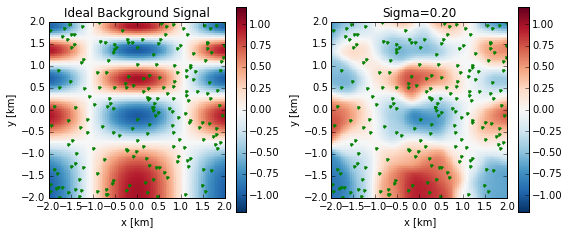

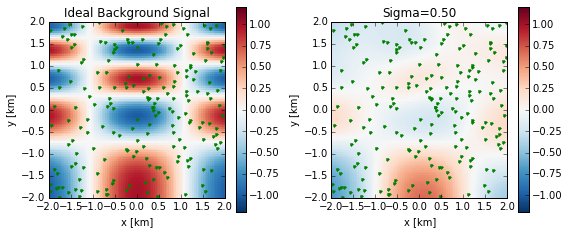

In [13]:
nx = len(xi)
ny = len(yi)
Zi = np.zeros((ny,nx))
for sigma in [0.05, 0.2,0.5]:
    for i in range(nx):
        for j in range(ny):
            rsq = (xi[i]-x)**2+(yi[j]-y)**2
            w=np.exp(-rsq/2./sigma**2)
            w=w/np.sum(w)
            Zi[j,i]=np.sum(w*z)    
    plotCompareInterp(xi,yi,Zi,titl='Sigma=%1.2f'%sigma)

Obviously there is some art to determining the value of $\sigma$ to use if you do this by hand. There are schemes for determining the spatial scale $\sigma$ emperically from the co-variance of the data.  

## Local Methods

The methods above use all the data for the interpolation, weighted appropriately by the data's distance from the grid point $x_i,y_i$. Another approach is to use the data that is nearest the grid point in two dimensions.  The most straightforward geometry to consider is a triangle of three data points that encompas the grid point.  

#### Veroni Cells and Delaunay Triangulation

A Veroni cell is associated with one of the data points $\mathbf{x}_n = (x_n,y_n)$, and is the region where any point inside the region is closer to $\mathbf{x}_n$ than to any other data point. We can denote the area of the Veroni cell as $A_n$, and there is one such area associated with each data point.  

Below we will see that we can construct a **Veroni Diagram** for our data set ${\mathbf{x_n}}$.  A sensible way to derive a value for a grid point $\mathbf{x_i}$ is to remake the Veroni diagram with the new data point included.  The new data point will "steal" area from three other Veroni cells.  If this area is $a_m=A_m-A_m'$, where $A_m'$ is the new area of the Veroni cell, then a reasonable interpolation is 

$$\hat{z}_i = \frac{\sum_{adjacent} a_m z_m}{\sum_{adjacent} a_m}$$

So this is easy, if only we could compute a **Veroni Diagram**.  This requires **Delaunay Triangulation**.  This is a neat geometric procedure that will give us the Veroni cells.  A triangulation is connecting all the data points together so that the resulting connections form triangles.  A **Delaunay Triangulation** additionally requires that *none* of the triangles may be connected so that their **circumcenters** lie inside another triangle.  

A triangle **circumcircle** is the unique circle that passes through each vertex of the triangle.  The **circumcenter** is the center of that circle.  See the plot below!

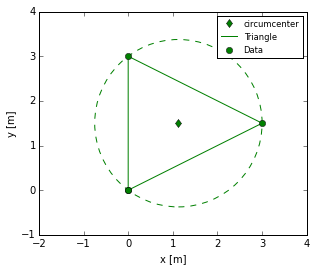

In [29]:
from matplotlib.patches import Circle, Wedge, Polygon

x = np.array([[0., 0.],[-0.6, 1.5],[0., 3.],[3., 1.5]])

def circumcenter(x,ind):
    a=x[ind[0],:]
    b=x[ind[1],:]
    c=x[ind[2],:]
    u=np.zeros(2)
    D = 2*(a[0]*(b[1]-c[1])+b[0]*(c[1]-a[1])+c[0]*(a[1]-b[1]))
    u[0] = (a[0]**2+a[1]**2)*(b[1]-c[1])
    u[0] = u[0]+(b[0]**2+b[1]**2)*(c[1]-a[1])
    u[0] = u[0]+(c[0]**2+c[1]**2)*(a[1]-b[1])
    u[0]=u[0]/D
    u[1] = (a[0]**2+a[1]**2)*(c[0]-b[0])
    u[1] = u[1]-(b[0]**2+b[1]**2)*(c[0]-a[0])
    u[1] = u[1]-(c[0]**2+c[1]**2)*(a[0]-b[0])
    u[1]=u[1]/D
    r = np.sqrt((u[0]-a[0])**2 + (u[1]-a[1])**2) 
    return u,r

ind = np.array([0,2,3])
u,r = circumcenter(x,ind)
fig,ax=plt.subplots()
ax.plot(u[0],u[1],'gd',label='circumcenter')
cir = Circle((u[0],u[1]),r,edgecolor='g',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
tri = [0, 1, 2, 0]
ax.plot(x[ind[tri],0],x[ind[tri],1],'g',label='Triangle')
ax.plot(x[ind[tri],0],x[ind[tri],1],'go',label='Data')
ax.set_xlim([-2.,4.]);ax.set_ylim([-1.,4.]); ax.set_xlabel('x [m]');ax.set_ylabel('y [m]')
ax.set_aspect(1.)
ax.legend(fontsize='small',numpoints=1)

The above shows three data points, the triangle they form, and the **circumcircle** and **circumcenter** of that triangle.  Note the code for the circumcircle is a bit ungly, but is just relatively simple geometry. 

Now we add a data point and do the most naive triangulation, which is to triangulate to the nearest edge of the existing triangle:

[0, 1, 2, 0]


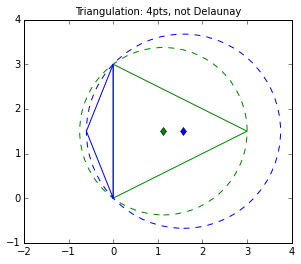

In [39]:
fig,axs=plt.subplots()
ax=axs
ind = np.array([0,2,3])
u,r = circumcenter(x,ind)
ax.plot(u[0],u[1],'gd')
cir = Circle((u[0],u[1]),r,edgecolor='g',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
tri = [0, 1, 2, 0]
print tri
ax.plot(x[ind[tri],0],x[ind[tri],1],'g')

ind = np.array([0,1,2])
u,r = circumcenter(x,ind)
ax.plot(u[0],u[1],'bd')
cir = Circle((u[0],u[1]),r,edgecolor='b',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
ax.set_xlim((-2,4.))
ax.set_ylim((-1,4));ax.set_aspect(1)
ax.plot(x[ind[tri],0],x[ind[tri],1],'b')
ax.set_title('Triangulation: 4pts, not Delaunay',fontsize=10)


The new triangle (blue) has a circumcenter that is inside the green triangle.  So this is *not* a valid Delaunay triangulation.  We note this, and "flip" the triangulation.  The "flip" operation means that we take the vertices that are shared and make them not shared, and the vertices that are not shared and make them shared:

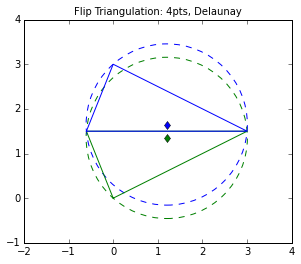

In [40]:
fig,ax=plt.subplots()
ind = np.array([0,1,3])
u,r = circumcenter(x,ind)

ax.plot(u[0],u[1],'gd')
cir = Circle((u[0],u[1]),r,edgecolor='g',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
ax.plot(x[ind[tri],0],x[ind[tri],1],'g')

ind = np.array([1,2,3])
u,r = circumcenter(x,ind)
ax.plot(u[0],u[1],'bd')
cir = Circle((u[0],u[1]),r,edgecolor='b',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
ax.set_xlim((-2,4.))
ax.set_ylim((-1,4))
ax.set_aspect(1)
ax.plot(x[ind[tri],0],x[ind[tri],1],'b')
ax.set_title('Flip Triangulation: 4pts, Delaunay',fontsize='10')


The new "flipped" triangulation is "Delaunay".  The circumcenters are not inside the any other triangles but their own.  It is non-trivial to prove, but flipping a non-Dealuney pair *always* yields this result.  

If we add more points we carry on the same way:

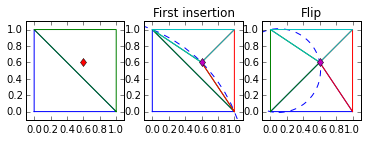

In [49]:
xp =np.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.]])
tri=np.array([[0,1,3],[1,3,2]])
fig,axs=plt.subplots(1,3)
ax=axs[0]
for ind in range(0,2):
    triind = [0,1,2,0]
    ax.plot(xp[tri[ind,triind],0],xp[tri[ind,triind],1])
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_aspect(1)

xnew = [0.6,0.6]
ax.plot(xnew[0],xnew[1],'d')

ax=axs[1]
xp = np.vstack((xp,xnew))
tri=np.array([[0,1,3],[1,3,4],[1, 4, 2],[3, 4, 2]])
for ind in range(0,4):
    triind = [0,1,2,0]
    ax.plot(xp[tri[ind,triind],0],xp[tri[ind,triind],1])
ax.set_aspect(1)
ax.plot(xnew[0],xnew[1],'d')
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))

u,r = circumcenter(xp,tri[1])
cir = Circle((u[0],u[1]),r,edgecolor='b',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
ax.set_title('First insertion')

tri=np.array([[0,1,4],[0,3,4],[1, 4, 2],[3, 4, 2]])
ax=axs[2]
for ind in range(0,4):
    triind = [0,1,2,0]
    ax.plot(xp[tri[ind,triind],0],xp[tri[ind,triind],1])
ax.set_aspect(1)
ax.plot(xnew[0],xnew[1],'d')
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))

u,r = circumcenter(xp,tri[1,:])
cir = Circle((u[0],u[1]),r,edgecolor='b',linestyle='dashed',facecolor=None)
cir.set_facecolor('none')
ax.add_artist(cir)
ax.set_title('Flip')

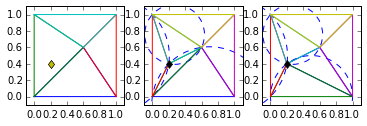

In [53]:
fig,axs=plt.subplots(1,3)
tri=np.array([[0,1,4],[0,3,4],[1, 4, 2],[3, 4, 2]])
xnew = [0.2,0.4]
ax=axs[0]
for ind in range(0,4):
    triind = [0,1,2,0]
    ax.plot(xp[tri[ind,triind],0],xp[tri[ind,triind],1])
ax.set_aspect(1)
ax.plot(xnew[0],xnew[1],'d')
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.plot(xnew[0],xnew[1],'d')

ax=axs[1]
xp = np.vstack((xp,xnew))
tri=np.array([[0,1,4],[0,5,4],[0,5,3],[3,5,4],[1, 4, 2],[3, 4, 2]])
for ind in range(0,6):
    triind = [0,1,2,0]
    ax.plot(xp[tri[ind,triind],0],xp[tri[ind,triind],1])
ax.set_aspect(1)
ax.plot(xnew[0],xnew[1],'d')
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
for ind in [1,2,3]:
    u,r = circumcenter(xp,tri[ind,:])
    cir = Circle((u[0],u[1]),r,edgecolor='b',linestyle='dashed',facecolor=None)
    cir.set_facecolor('none')
    ax.add_artist(cir)

ax=axs[2]
xp = np.vstack((xp,xnew))
tri=np.array([[5,1,4],[0,5,1],[0,5,3],[3,5,4],[1, 4, 2],[3, 4, 2]])
for ind in range(0,6):
    triind = [0,1,2,0]
    ax.plot(xp[tri[ind,triind],0],xp[tri[ind,triind],1])
ax.set_aspect(1)
ax.plot(xnew[0],xnew[1],'d')
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
for ind in [1,2,3]:
    u,r = circumcenter(xp,tri[ind,:])
    cir = Circle((u[0],u[1]),r,edgecolor='b',linestyle='dashed',facecolor=None)
    cir.set_facecolor('none')
    ax.add_artist(cir)

The process of going through this algorithmically takes some care, particularly for edge cases.  Fortunately it is done for us in many numerical packages.  For python we use `matplotlib.delaunay`, the circumcenter of each triange, the edges of each triangle, the vertices, and the triangle's neighbours.

/Users/jklymak/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


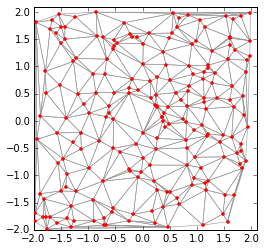

In [57]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from scipy import interpolate
from scipy import ndimage

#from jmkfigure import *

# make up some randomly distributed data
seed(1234)
npts = 200
Nx = 40
Ny=Nx
#define the data points
x = uniform(-2,2,npts)
y = uniform(-2,2,npts)
# define grid we will interpolate to.  
xi = np.linspace(-2.1,2.1,Nx)
yi = np.linspace(-2.1,2.1,Ny)

zactual=np.random.randn(Nx,Ny)
nn=np.floor(Nx/5)
zactual = ndimage.convolve(zactual,np.ones((nn,nn))/(nn*nn*1.0))
zactual=zactual-zactual.mean()
zactual=zactual/zactual.std()/4.
f=interpolate.interp2d(xi,yi,zactual)
print f
z=0.*x
for ind in range(npts):
    z[ind] = f(x[ind],y[ind])

#djmkfigure(2,0.4)    

import matplotlib.delaunay as triang

cens,edg,tri,neig = triang.delaunay(x,y)

fig,ax=plt.subplots(1,1)

for t in tri:
 # t[0], t[1], t[2] are the points indexes of the triangle
 t_i = [t[0], t[1], t[2], t[0]]
 ax.plot(x[t_i],y[t_i],'0.6',lw=0.6,zorder=1)

ax.plot(x,y,'o',c='r',markersize=3,mec='r',zorder=10)
ax.set_xlim((-2,2.1))
ax.set_ylim((-2,2.1))
ax.set_aspect(1)

*How* does this help us get the **Voronoi cells**?  If two triangles share an edge, then the line connecting their *circumcenters* is an edge of a **Voronoi cell**.  To find the Voronoi cell for a given data point, you find the triangles that have that point as a vertex, and then you find the cell edges, connect them "properly" and then you will have the cell you are interested in.

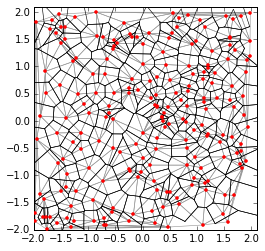

In [33]:
N = shape(tri)[0]

for ind in range(N):   
    for j in range(3):
        inds= [ind,neig[ind,j]]
        if (cens[inds[1],1]<2.):
            ax.plot(cens[inds,0],cens[inds,1],'k',lw=0.6)
display(fig)

### You aren't going to make us code this are you?

This is relatively straightforward, but incredibly fussy to program, so of course python provides ways to do all this work.  The `matplotlib.mlab.griddata` command will interpolate in one of two ways using Delaunay triangulation: Natural neighbour interpolation, or linear interpolation.  

**NOTE** `matplotlib.mlab.griddata` requires https://github.com/matplotlib/natgrid to be installed.  If that is a problem, then `scipy.interpolate.griddata` works similarly...

Natural neighbour interpolation performs the algorithm described above: 
  
  1. Insert the grid point into the triangulation and re-triangulate.
  2. Determine how much area was required from the three surrounding data points' **Voronoi cells**
  3. Perform a weighted average of the three data points. 
 
This weights the data in a systematic way based on the closeness of the gridpoint to the data nearby.

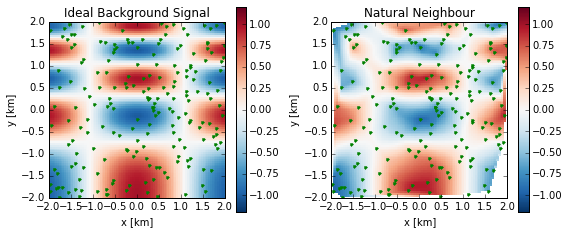

In [55]:
# make up some randomly distributed data
seed(1234)
npts = 200
# the randomly distributed data points $x_n,y_n$:
x=uniform(-2,2,npts)
y=uniform(-2,2,npts)
z = cos(x*2*pi/4.3)*signal.chirp(y+2.,f0=.05,t1=4.,f1=1.)
# lets also get it on the grid.
xi = np.linspace(-2.,2.,100)
yi = np.linspace(-2.,2.,100)
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
X,Y=np.meshgrid(xi,yi)
zideal = cos(X*2*pi/4.3)*signal.chirp(Y+2,f0=.05,t1=4.,f1=1)

# 
zi = mlab.griddata(x,y,z,xi,yi,interp='nn')
plotCompareInterp(xi,yi,zi,titl='Natural Neighbour')

This is arguably superior to the gridding perfomed by the universal weighting performed above.  It certainly maintains more of the scales of variability.  There are obvious errors near the edges, but that is  because this agorithm does not extrapolate into undefined Voronoi cells.

Linear interpolation is slightly more jagged:

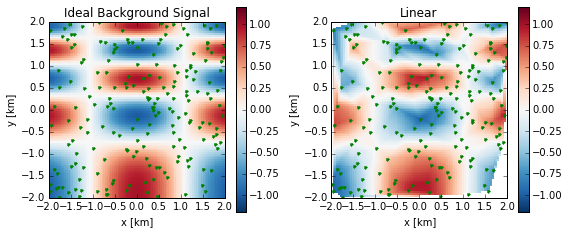

In [56]:
# 
zi = mlab.griddata(x,y,z,xi,yi,interp='linear')
plotCompareInterp(xi,yi,zi,titl='Linear')

The `scipy.iterpolate.griddata` is a bit clunkier to use, and doesn't have Nearest-neighbourhood, but its 'cubic' option works quite well here:

(100, 100)
(200,)
(100, 100)
(100,)


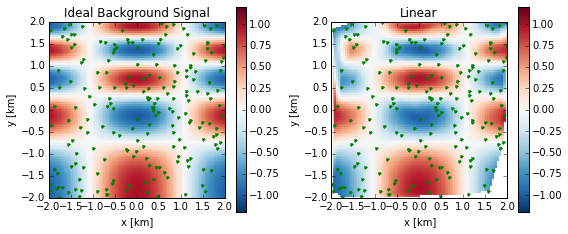

In [59]:
import scipy.interpolate as interpolate
Xx = np.vstack((x,y)).T
print shape(X)
print shape(z)
Xi,Yi=meshgrid(xi,yi)
zi = interpolate.griddata(Xx,z,(Xi,Yi),method='cubic')
print shape(zi)
print shape(yi)
plotCompareInterp(xi,yi,zi,titl='Linear')

##     Which should I use?

The choice of which interpolant to use is somewhat artistic.  In general if your data is not noisy, then the "local" methods work quite well. On the other hand if you have significant noise in your data, then you may want to do some smoothing at some scale anyways.  In that case, the global methods are quite effective and lend themselves to a natural interpretation.

As mentioned above the global methods can also be made more "objective" by computing the decorrelation lengthscales of the data.  The example used above would be a bad example for that treatment, but often statistics of data have natural spatial scales, so gridding knowing those is useful.